In [1]:
import numpy as np
from numpy import fft

from qiskit.opflow import MatrixOp, TensoredOp, SummedOp

#import qtealeaves.observables as obs
#from qmatchatea.qk_utils import qiskit_get_statevect
#from qmatchatea import QCConvergenceParameters, QCOperators, QCBackend
#from qmatchatea.py_emulator import run_py_simulation

from qiskit import QuantumCircuit, assemble, transpile, QuantumRegister, AncillaRegister, Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

In [2]:
from losstre import *
from tqdm import trange

## Hamming distance count

In [3]:
def Hamming_count(num_qubits, num_ancillas, train_data, init_qc=None):
    """ 
    Generate circuit with `num_qubits` qubits and `num_ancillas` ancillas used to count the
    distance from the training data. The count is stored in the ancillary qubits, so num_ancillas has to be large
    enough to store the extremum case (no control is performed yet).
        - train_data: vector of training data with the convention

        Conventions:
        - (1,-1) <--> (|0>,|1>)
        - little endians: least significant bit is the last one of the string
    """
    if init_qc is not None:
        circ = init_qc.copy()
        qreg = circ.qubits[:num_qubits]
        areg = circ.qubits[-num_ancillas:]
    else:
        qreg, areg = QuantumRegister(num_qubits), AncillaRegister(num_ancillas)
        circ = QuantumCircuit(qreg, areg)

    # flip only when the training data is -1: in this way the circuit can simply count the number 
    # of states that are |1>
    # little endians convention is applied !!! train_data[::-1] !!!
    for iq, train_data_i in enumerate(train_data[::-1]):
        if train_data_i == -1:
            circ.x(qreg[iq])

    # initial Hadamards to create superposition in the ancillary register
    for ia in range(len(areg)):
        circ.h(areg[ia])
    
    
    # Phase estimation
    for ia in range(len(areg)):
        # the order is from the lowest index of the ancilla to the highest
        n_reps = 2**ia

        # repeat n_reps times the application of the unitary gate controlled on the ancillary qubit
        for rep_idx in range(n_reps):
            for iq in range(len(qreg)):
                circ.cp(2*np.pi/2**num_ancillas, areg[ia], qreg[iq])
                
    circ.barrier()
    qft_circ = QFT(num_ancillas, inverse=True).decompose(reps=1)

    return circ.compose(qft_circ, areg)

In [4]:
def U_z(num_qubits, num_ancillas, ancilla_index, train_data, gamma, init_qc=None):

    # define circuit
    if init_qc is not None:
        circ = init_qc.copy()
        qreg = circ.qubits[:num_qubits]
        areg = circ.qubits[-num_ancillas:]
    else:
        qreg, areg = QuantumRegister(num_qubits), AncillaRegister(num_ancillas)
        circ = QuantumCircuit(qreg, areg)
    
    circ.barrier()

    # define controlled operation on the 'ancilla_index'
    # little endians convention is applied !!! iq and idata goes on opposite directions !!!
    for iq, idata in zip(range(len(qreg)),range(len(train_data)-1,-1,-1)):
        circ.crz(-2*gamma*train_data[idata]/np.sqrt(num_qubits), areg[ancilla_index], qreg[iq])

    circ.barrier()
    return circ

In [5]:
N_xi, N_features = 1, 7
#N_xi, N_features =  8, 10

x = np.random.randint(2, size=(N_xi, N_features))
x[ x == 0 ] = -1  # data is encoded as +- 1

csi_patterns = x #np.array([1,1,1,1,1,1,1]).reshape(1,-1)



N_csi, N = csi_patterns.shape
k = int(np.ceil(np.log2(N+1)))

labels = np.ones((N_csi, ))

### evolution test

In [6]:
qc = QuantumCircuit(QuantumRegister(N), AncillaRegister(k))

for ii in range(N):
    qc.h(ii)

#for ii, el in enumerate( csi_patterns[0,:][::-1] ):
#    if el == -1: qc.x(ii)

mystates = []
mystates.append( get_statevec(qc, N) )

In [7]:
P = 100
dt = 1

for pp in trange(P):
    s_p = (pp+1)/P
    gamma_p = s_p*dt
    beta_p = (1-s_p)*dt

    for mu in range( N_csi ):
    #
    #    # create Hamming error counter circuit based on the given pattern
        qc_counter = Hamming_count(N,k, train_data=csi_patterns[mu,:], init_qc=None)
        qc_counter_inverse = qc_counter.inverse()
    #
    #    # create evolution circuit
        U_z_prova = U_z(N, k, k-1, train_data=csi_patterns[mu,:], gamma=gamma_p, init_qc=None)
    #
        qc = qc.compose(qc_counter)
        qc = qc.compose(U_z_prova)
        qc = qc.compose(qc_counter_inverse)

    # measure loss
    mystates.append( get_statevec(qc, N) )

    # apply Ux
    for ii in range( N ):
    #    # syntax:  lambda, control_qubit, target_qubit
        qc.u( 2 * beta_p, np.pi/2, -np.pi/2, ii)

    


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [8]:
print(get_losses_from_sts(mystates, csi_patterns, labels, representation='same'))

Constructing H_perc: 100%|██████████| 1/1 [00:00<00:00, 599.27it/s]

[0.05905695+0.00000000e+00j 0.05905695+0.00000000e+00j
 0.05898422+0.00000000e+00j 0.05896105+0.00000000e+00j
 0.05898257+0.00000000e+00j 0.0588998 +0.00000000e+00j
 0.05885685+0.00000000e+00j 0.05890782+0.00000000e+00j
 0.05881294+0.00000000e+00j 0.05876417+0.00000000e+00j
 0.05882867+1.23908820e-19j 0.05873868+0.00000000e+00j
 0.05867786+2.47817639e-19j 0.05873232+2.47817639e-19j
 0.05876069+0.00000000e+00j 0.05862709+0.00000000e+00j
 0.05862071+0.00000000e+00j 0.05883849+0.00000000e+00j
 0.05878784-4.95635279e-19j 0.05869312+0.00000000e+00j
 0.05899697+0.00000000e+00j 0.05940818+0.00000000e+00j
 0.05963446+1.98254112e-18j 0.06001471+3.96508223e-18j
 0.06112402+0.00000000e+00j 0.06245402-3.96508223e-18j
 0.06385534+0.00000000e+00j 0.06532171+0.00000000e+00j
 0.06722497-9.91270558e-19j 0.06850664+2.47817639e-19j
 0.06841608+0.00000000e+00j 0.06673601+0.00000000e+00j
 0.06441549+0.00000000e+00j 0.06274415+0.00000000e+00j
 0.06285415+9.91270558e-19j 0.06565635-1.98254112e-18j
 0.0683086

In [9]:
loss = get_losses_from_sts(mystates, csi_patterns, labels, representation='same')

Constructing H_perc: 100%|██████████| 1/1 [00:00<00:00, 620.73it/s]


/home/baronefr/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


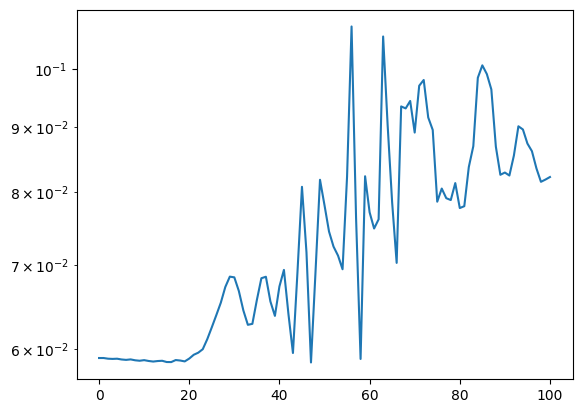

In [10]:
import matplotlib.pyplot as plt 
plt.plot(loss)
plt.yscale('log')

In [11]:
prb = qi.Statevector.from_instruction(qc).probabilities()[:2**7]

In [12]:
max_idx = np.argmax( prb )

In [13]:
np.argsort(prb)[::-1][:5]

array([  2,  16,   1,  64, 119])